# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [5]:
import os
import tqdm
import numpy
import torch
import pandas
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2

In [6]:
# Можно использовать, но балл за соответствующие задания будет снижен.
import pytorch_metric_learning.distances
import pytorch_metric_learning.samplers
import pytorch_metric_learning.losses

In [7]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)

print(f"Device: {device}")

Device: mps


In [8]:
device

device(type='mps')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [16]:
import os
from collections import Counter
from PIL import Image

def collect_sizes(root_dir):
    sizes = []
    for root, dirs, files in os.walk(root_dir):
        for name in files:
            path = os.path.join(root, name)
            with Image.open(path) as img:
                    sizes.append(img.size) 
    return sizes

train_sizes = collect_sizes("data/training")
test_sizes = collect_sizes("data/testing")

size_counts = Counter(train_sizes + test_sizes)
total = sum(size_counts.values())

print(f"Всего изображений: {total}")
print("Топ популярных разрешений:")

for (w, h), cnt in size_counts.most_common(10):
    pct = cnt / total * 100
    print(f"{w}x{h}: {cnt} штук ({pct:.2f}%)")

print(f"Уникальных разрешений: {len(size_counts)}")

Всего изображений: 1101
Топ популярных разрешений:
250x250: 1101 штук (100.00%)
Уникальных разрешений: 1


Получается у нас есть 1001 изображение, каждое с разрещением 250x250. Так же видно padding в изображениях.

In [17]:
import torchvision.transforms.v2 as v2

set_random_seed(42)

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5]),
])

train_ds = torchvision.datasets.ImageFolder("data/training", transform=transform)
test_ds  = torchvision.datasets.ImageFolder("data/testing",  transform=transform)

print(f"Количество изображений: train={len(train_ds)}, test={len(test_ds)}")
print(f"Классов (людей): {len(train_ds.classes)}")

Количество изображений: train=1065, test=36
Классов (людей): 148


1. Переводим PIL в Tensor
2. Нормализуем значения в [0,1]
3. Центрируем данные вокруг 0 ([-1,1])

Нормализация помогает модели обучаться стабильнее и быстрее сходиться.

$$ x’ = \frac{x - 0.5}{0.5} = 2x - 1, \quad x \in [0, 1], \; x’ \in [-1, 1] $$

Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

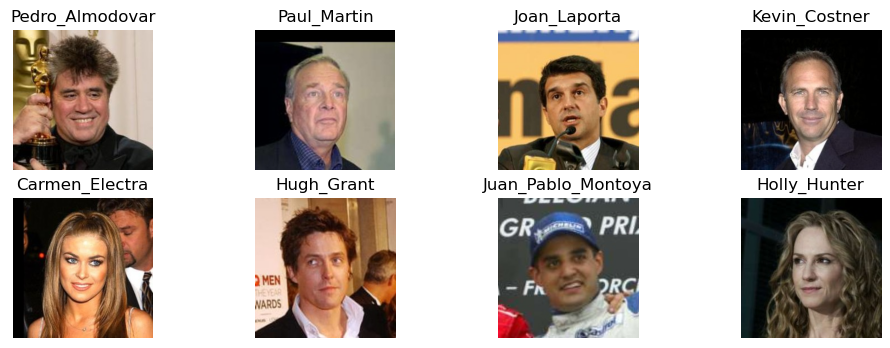

In [29]:
plt.figure(figsize=(12, 4))

# 8 случайных изображений
indices = random.sample(range(len(train_ds)), 8)

for i, idx in enumerate(indices):
    img, label = train_ds[idx]
    # обратная нормализация
    img = (img * 0.5 + 0.5).clamp(0, 1)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(train_ds.classes[label])

plt.show()

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

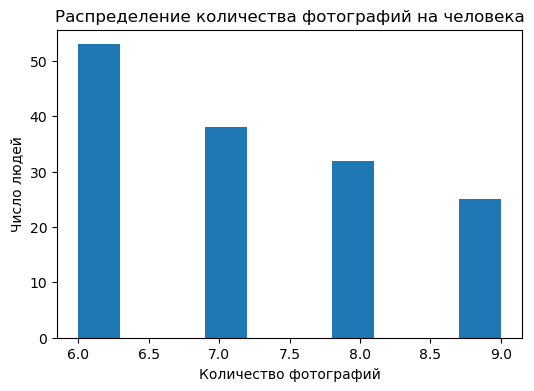

Минимум фото: 6
Максимум фото: 9


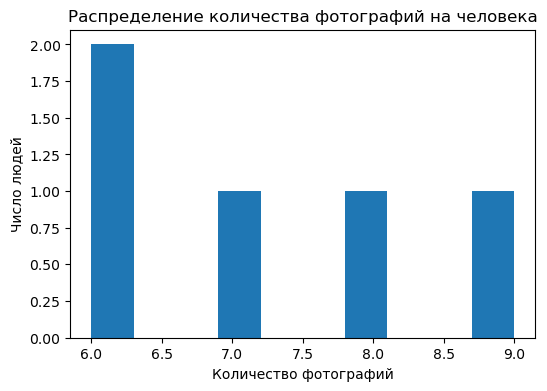

Минимум фото: 6
Максимум фото: 9


In [31]:
def show_class_distribtion(targets):
    counts = Counter(targets)  
    values = list(counts.values())

    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=10)
    plt.title("Распределение количества фотографий на человека")
    plt.xlabel("Количество фотографий")
    plt.ylabel("Число людей")
    plt.show()

    print(f"Минимум фото: {min(values)}")
    print(f"Максимум фото: {max(values)}")

# вызов
show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

Все верно! у каждого класса (человека) 6-9 изображений

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [32]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)
    
    def _idx2(self, idx):
        return idx // len(self.dataset)
    
    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)
    
train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 2602114.88it/s]


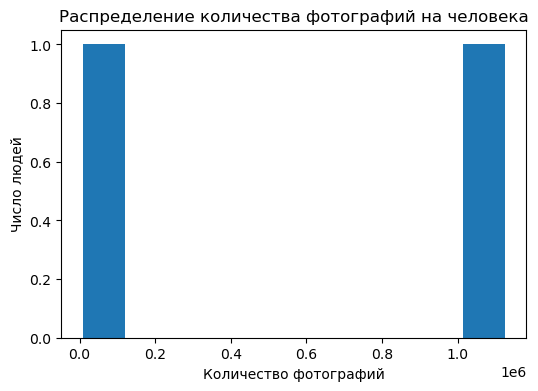

Минимум фото: 7843
Максимум фото: 1126382


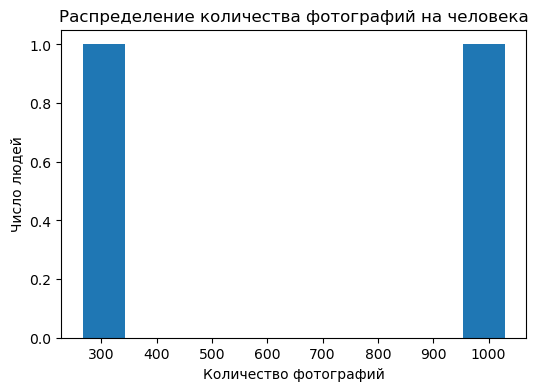

Минимум фото: 266
Максимум фото: 1030


In [33]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [35]:
from torch.utils.data import Sampler

class BalancedSampler(Sampler):
    def __init__(self, targets):
        self.targets = torch.tensor(targets)
        self.indices_0 = torch.where(self.targets == 0)[0].tolist()
        self.indices_1 = torch.where(self.targets == 1)[0].tolist()

    def __iter__(self):
        random.shuffle(self.indices_0)
        random.shuffle(self.indices_1)
        n = min(len(self.indices_0), len(self.indices_1))
        mixed = [None] * (2 * n)
        mixed[::2], mixed[1::2] = self.indices_0[:n], self.indices_1[:n]
        return iter(mixed)

    def __len__(self):
        return 2 * min(len(self.indices_0), len(self.indices_1))

In [36]:
train_pairs_sampler = BalancedSampler(train_pairs.targets)

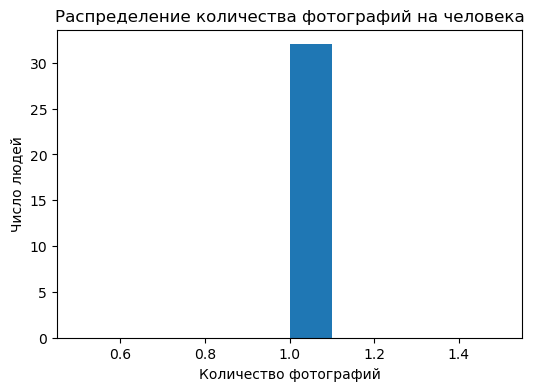

Минимум фото: 1
Максимум фото: 1


In [37]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.
show_class_distribtion(next(iter(train_pairs_loader))[2])

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

<img src="./siamese_scheme.png" alt="Сиамская сеть" width="500">

## Siamese Network

Я изучил подходы к бинарной классификации изображений и нашёл, что одной из наиболее эффективных архитектур является **Siamese Network**.  
Ее цель — научиться определять, принадлежат ли два изображения одному классу.


### Классический подход: Contrastive Loss

Классически сеть использует пары изображений $(x_i, x_j)$  
и метку $z_{ij} \in \{0,1\}$ (0 — одинаковые, 1 — разные):

$$
\mathcal{L}_{\text{contrastive}}(x_i, x_j, z_{ij}) =
(1 - z_{ij}) \|h_i - h_j\|_2^2 +
z_{ij} \max(0, \tau - \|h_i - h_j\|_2)^2
$$

где $h_i, h_j$ — эмбеддинги, $\tau$ — порог-дистанция.  
Сеть минимизирует расстояние между схожими и отталкивает несхожие эмбеддинги.


### Современный подход: MLP + BCE

В более поздней работе [Koch et al., *Siamese Neural Networks for One-shot Image Recognition* (2015)](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
вместо фиксированной метрики используется обучаемый блок — **MLP**.  
CNN создаёт эмбеддинги, их разность подаётся в MLP, который выдаёт логит $z$:

$$
E_1 = f_{\text{CNN}}(x_1), \quad E_2 = f_{\text{CNN}}(x_2)
$$

$$
d = |E_1 - E_2|, \quad z = f_{\text{MLP}}(d)
$$

Вероятность принадлежности разным классам вычисляется через сигмоиду:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

и обучается с помощью **бинарной кросс-энтропии (BCE)**:

$$
\mathcal{L}_{\text{BCE}} = -[y \log(\sigma(z)) + (1 - y)\log(1 - \sigma(z))]
$$

где $y \in \{0,1\}$ — истинная метка.


## Как работает наша модель

1. Обе картинки проходят через одну **CNN** с общими весами → получаем эмбеддинги $E_1$ и $E_2$.  
   Внутри CNN используются **BatchNorm** и **ReLU** —  
   BatchNorm стабилизирует обучение, нормализуя активации и ускоряя сходимость,  
   а ReLU добавляет нелинейность, позволяя сети учить сложные зависимости.

2. Считаем разность эмбеддингов $|E_1 - E_2|$, которая отражает различия между изображениями (модуль дает инвариантность).

3. Разность подаётся в небольшой **MLP**, где добавлен **Dropout (p=0.4)** —  
   он случайно “отключает” часть нейронов во время обучения, предотвращая переобучение  
   и повышая обобщающую способность модели.

4. MLP преобразует разность в **логит** $z$ — численную уверенность модели.

5. Через сигмоиду вычисляется вероятность насколько изображения принадлежат **разным классам (людям)**.

6. Модель обучается по **BCE (Binary Cross-Entropy)**,  
   обновляя веса CNN и MLP одновременно — **end-to-end** обучение.

https://neerc.ifmo.ru/wiki/index.php?title=%D0%A1%D0%B8%D0%B0%D0%BC%D1%81%D0%BA%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C


https://builtin.com/machine-learning/siamese-network

In [44]:
import torch.nn as nn

class ClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2)  
        )

        # MLP 
        self.mlp = nn.Sequential(
            nn.Linear(64 * 29 * 29, 128), 
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, image1, image2):
        e1 = self.cnn(image1).flatten(1)
        e2 = self.cnn(image2).flatten(1)
        diff = torch.abs(e1 - e2)
        logit = self.mlp(diff).squeeze(1)
        return logit

In [45]:
# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

In [46]:
from torch import optim

model = ClassificationNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress = tqdm.tqdm(train_pairs_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for img1, img2, labels in progress:
        img1, img2, labels = img1.to(device), img2.to(device), labels.float().to(device)

        optimizer.zero_grad()
        logits = model(img1, img2)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress.set_postfix({"train_loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_pairs_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] — average loss: {avg_loss:.4f}")

Epoch [1/10] — average loss: 0.6325


Epoch [2/10] — average loss: 0.5430


Epoch [3/10] — average loss: 0.4986


Epoch [4/10] — average loss: 0.4444


Epoch [5/10] — average loss: 0.4134


Epoch [6/10] — average loss: 0.3848


Epoch [7/10] — average loss: 0.3566


Epoch [8/10] — average loss: 0.3390


Epoch [9/10] — average loss: 0.3225


Epoch [10/10] — average loss: 0.2946


In [50]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

auc_roc = get_auc_roc(model)
print(auc_roc.round(3), get_score(auc_roc))

100%|██████████| 21/21 [00:02<00:00,  7.24it/s]

0.957 2.5


### 🎉 Ура, $AUC-ROC = 0,95$, это очень крутой результат, даже не ожидал, хотя честно много времени на ресерч потратил, так же свою роль сыграл Dropout и BatchNorm.

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

Модель показала высокий результат ($AUC\text{-}ROC \approx 0.95$), что объясняется современным подходом с MLP + BCE, а также использованием Dropout и BatchNorm, улучшивших обобщающую способность.

Ограничения текущей модели:
1.	Ограниченность информации при обучении — сеть видит только пары “одинаковый/разный” и не строит общее пространство признаков.
2.	Плохое масштабирование — при большом количестве пользователей нужно формировать огромное число пар.
3.	Зависимость от разметки — при несбалансированных или неудачных парах модель склонна к тривиальным предсказаниям (“всегда разные”).

Однако для реальных систем вроде «Оплата улыбкой» от Сбера такая модель не подойдёт — придётся сравнивать лицо пользователя со всеми в базе.
Лучше использовать embedding-based подход, обучая сеть строить устойчивые вектора лиц (эмбеддинги); в этом случае можно увеличить размерность последнего линейного слоя и работать напрямую с расстояниями между эмбеддингами (например cosin уже после выхода модели).
Или использовать Triplet model с собственной функцией потерь, чтобы обучать CNN формировать эмбеддинги, отражающие степень сходства между лицами.


### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [53]:
import torch.nn.functional as F

class BatchAllTripletLoss(nn.Module):
    def __init__(self, margin: float = 0.25):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        # embeddings: (B, D), labels: (B,)
        device = embeddings.device
        labels = labels.view(-1)
        B = embeddings.size(0)

        # попарные расстояния L2
        dist = torch.cdist(embeddings, embeddings, p=2)

        # маски для pos и neg
        labels_eq = labels.unsqueeze(0) == labels.unsqueeze(1)  # (B, B)
        mask_pos = labels_eq & ~torch.eye(B, dtype=torch.bool, device=device)  # одинаковый класс, не сам с собой
        mask_neg = ~labels_eq  # разный класс

        # формируем все комбинации (A, P, N)
        dist_ap = dist.unsqueeze(2)  
        dist_an = dist.unsqueeze(1)  

        mask_pos = mask_pos.unsqueeze(2)  
        mask_neg = mask_neg.unsqueeze(1) 

        valid_triplets = mask_pos & mask_neg  

        # считаем loss 
        triplet_loss = F.relu(dist_ap - dist_an + self.margin)

        # только валидные тройки
        if valid_triplets.any():
            triplet_loss = triplet_loss[valid_triplets].mean()
        else:
            triplet_loss = torch.tensor(0.0, device=device)

        return triplet_loss

criterion = BatchAllTripletLoss(margin=0.25)

In [54]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

<img src="./triplet_loss.png" alt="Triplet Loss" width="500">

https://www.v7labs.com/blog/triplet-loss

За основу возьмем архитектуру `ClassificationNet`, но вместо логита будем выводить вектор размерности 128 (dim=128). Такое значение выбрано как баланс между полнотой и компактностью: оно позволяет описывать каждого человека в пространстве из 128 признаков, не перегружая модель и сохраняя устойчивость обучения.

In [71]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        # такая же CNN как и в ClassificationNet
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        # projector
        self.fc = nn.Sequential(
            nn.Linear(64 * 29 * 29, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # нормируем чтобы расстояния были стабильнее
        x = F.normalize(x, p=2, dim=1)
        return x

Нужен самописный `Sampler`, чтобы в каждом батче было по `m` примеров на класс (иначе не собрать `A, P, N`).

In [72]:
from collections import defaultdict

class MPerClassSampler(Sampler):
    def __init__(self, labels, m=4, batch_size=64):
        self.labels = torch.as_tensor(labels)
        self.m = m
        self.batch_size = batch_size
        self.classes_per_batch = batch_size // m

        self.index_by_label = defaultdict(list)
        for idx, y in enumerate(self.labels.tolist()):
            self.index_by_label[y].append(idx)
        self.labels_set = list(self.index_by_label.keys())

    def __iter__(self):
        labels = self.labels_set.copy()
        random.shuffle(labels)

        batch = []

        for lbl in labels:
            idxs = self.index_by_label[lbl]
            if len(idxs) < self.m:
                continue
            # выбираем m разных примеров этого класса
            chosen = random.sample(idxs, self.m)
            batch.extend(chosen)

            if len(batch) == self.batch_size:
                yield batch
                batch = []

        # хвост < batch_size игнорируем

    def __len__(self):
        return len(self.labels) // self.batch_size

In [73]:
from torch.utils.data import DataLoader

train_labels = [y for _, y in train_ds]
sampler = MPerClassSampler(train_labels, m=4, batch_size=64)

triplet_train_loader = DataLoader(
    train_ds,
    batch_sampler=sampler
)

In [74]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

In [76]:
model = EmbeddingNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm.tqdm(triplet_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        emb = model(images)
        loss = criterion(emb, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(triplet_train_loader)
    auc = get_auc_roc(model)

    print(f"Epoch {epoch+1}/{num_epochs} | triplet_loss={avg_loss:.4f} | AUC-ROC={auc:.4f}")

100%|██████████| 21/21 [00:02<00:00,  7.56it/s]           


Epoch 1/10 | triplet_loss=0.1014 | AUC-ROC=0.7272


100%|██████████| 21/21 [00:02<00:00,  7.77it/s]           


Epoch 2/10 | triplet_loss=0.0636 | AUC-ROC=0.8117


100%|██████████| 21/21 [00:02<00:00,  7.86it/s]           


Epoch 3/10 | triplet_loss=0.0509 | AUC-ROC=0.8651


100%|██████████| 21/21 [00:02<00:00,  8.05it/s]           


Epoch 4/10 | triplet_loss=0.0361 | AUC-ROC=0.9127


100%|██████████| 21/21 [00:02<00:00,  7.89it/s]           


Epoch 5/10 | triplet_loss=0.0249 | AUC-ROC=0.9361


100%|██████████| 21/21 [00:02<00:00,  7.93it/s]           


Epoch 6/10 | triplet_loss=0.0171 | AUC-ROC=0.9453


100%|██████████| 21/21 [00:02<00:00,  7.92it/s]           


Epoch 7/10 | triplet_loss=0.0138 | AUC-ROC=0.9342


100%|██████████| 21/21 [00:02<00:00,  7.39it/s]           


Epoch 8/10 | triplet_loss=0.0096 | AUC-ROC=0.9317


100%|██████████| 21/21 [00:02<00:00,  7.78it/s]           


Epoch 9/10 | triplet_loss=0.0065 | AUC-ROC=0.9438


100%|██████████| 21/21 [00:02<00:00,  7.75it/s]            

Epoch 10/10 | triplet_loss=0.0043 | AUC-ROC=0.9428


Triplet-модель обучается значительно быстрее, чем предыдущая `ClassificationNet`, так как не использует MLP и работает напрямую с эмбеддингами.
Однако итоговый `AUC-ROC (~ 0.94)` чуть ниже, что объясняется меньшей выразительностью функции потерь.
Чтобы улучшить качество, стоит внедрить `hard` или `semi-hard triplet mining` — выбирать в батче наиболее сложные, близкие по признакам примеры.

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

# спасибо что проверил(а) работу!!!